In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from pathlib import Path, PureWindowsPath
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 20)

In [13]:
path = PureWindowsPath(os.getcwd() + "\\data\\input\\data.parquet")
path = path.as_posix()
corpus = pd.read_parquet(path) #engine="fastparquet"
corpus = corpus.sample(frac=1).reset_index(drop=True)
corpus["category_bin"] = np.select([corpus["category"] == "philosophy"], [1], default=0)
# corpus["category_bin"] = (corpus["category_bin"] == "philosophy")
corpus

,id,message,message_preprocessed,category,length,category_bin
0,212,Thomas le justifie par le ...,thomas justifie raisonneme...,philosophy,460,1
1,6830,jean-marc willigsecker sur...,jean-marc willigsecker jan...,baptism,56,0
2,4673,"> A l’objection du mal, S....",a objection mal augustin r...,philosophy,345,1
3,8142,Q. 73: Pourquoi donc le Sa...,q pourquoi donc saint-espr...,baptism,124,0
4,6775,"De plus, pourquoi Jésus ne...",plus pourquoi jésus serait...,baptism,329,0
5,7815,Auteur : **E.J. HUTCHINSON...,auteur ej hutchinson ej hu...,baptism,117,0
6,6582,Et vous êtes parfaitement ...,parfaitement comblés tête ...,baptism,574,0
7,2615,Christ a donc été à la foi...,christ a donc foi prêtre v...,philosophy,102,1
8,5672,"Puis, il poursuit en montr...",puis poursuit montrant all...,baptism,295,0
9,7459,Cet article s’inspire de [...,cet article inspire celui ...,baptism,125,0


In [14]:
X = corpus["message_preprocessed"]
y = corpus["category"]
y = corpus["category_bin"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [15]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

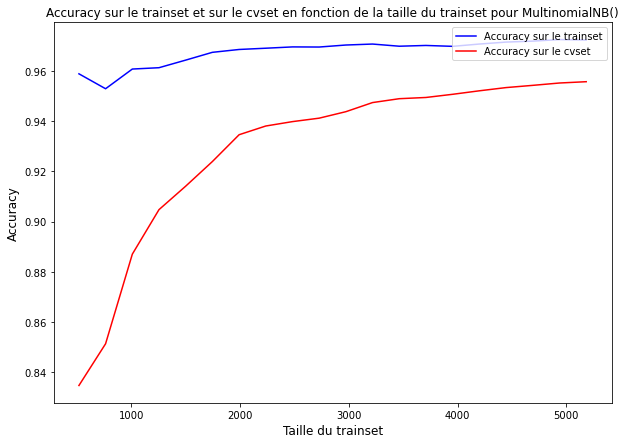

In [50]:
# Learning curves du modele selectionne : performances du modele en fonction de la taille du trainset
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score 
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
#Entrees
    #train_sizes (liste de float) : tailles du train en pourcentage 
    #cv_param : parametres de type kfold pour la cross validation
def get_learning_curve(model, X_train, y_train, cv_param, scoring, train_sizes, n_jobs=-1):
    # print("train_sizes =", 100 * train_sizes * len(y_train))
    train_sizes, train_scores, cv_scores = learning_curve(model, X_train, y_train, cv=cv_param, scoring=scoring, n_jobs=n_jobs, train_sizes=train_sizes)
    # learning_curve(AdaBoostClassifier(), X_train, y_train, cv=kfold, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    cv_scores_mean = np.mean(cv_scores, axis=1)
    cv_scores_std = np.std(cv_scores, axis=1)
    model_name = str(model)
    plt.figure()
    train_plot_label = scoring.capitalize() + " sur le trainset"
    cv_plot_label = scoring.capitalize() + " sur le cvset"
    title = scoring.capitalize() + " sur le trainset et sur le cvset en fonction de la taille du trainset pour " + model_name
    plt.plot(train_sizes, train_scores_mean, label=train_plot_label, color="b")
    plt.plot(train_sizes, cv_scores_mean, label=cv_plot_label, color="r")
    plt.title(title)
    plt.xlabel("Taille du trainset", fontsize=12)
    plt.ylabel(scoring.capitalize(), fontsize=12)
    plt.legend(loc="upper right")
    plt.show()

k = 10
# kfold = StratifiedKFold(n_splits=k, random_state=None, shuffle=True) #n_splits = k de la k-fold cv, le nombre de fold
kfold = RepeatedStratifiedKFold(n_splits=k, n_repeats=5, random_state=None)
model = MultinomialNB() 
scoring = 'accuracy'
cv_param = kfold 
num_experiences = 40
train_sizes = np.linspace(0.1, 1.0, num_experiences)
# train_sizes = np.linspace(0.001, 1.0, num_experiences)
n_jobs = -1

get_learning_curve(model, X_train_tfidf, y_train, cv_param, "accuracy", train_sizes, n_jobs)

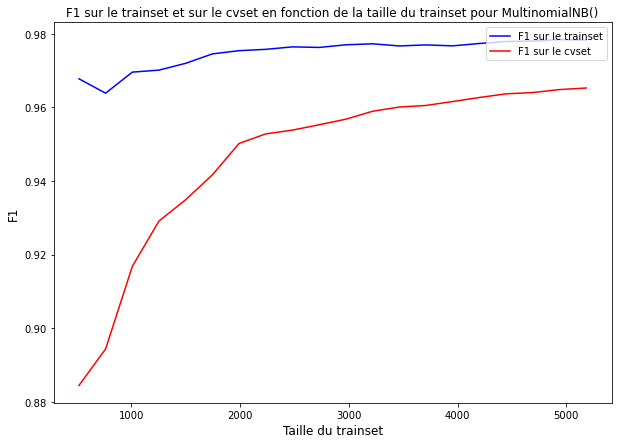

In [51]:
get_learning_curve(model, X_train_tfidf, y_train, cv_param, "f1", train_sizes, n_jobs)

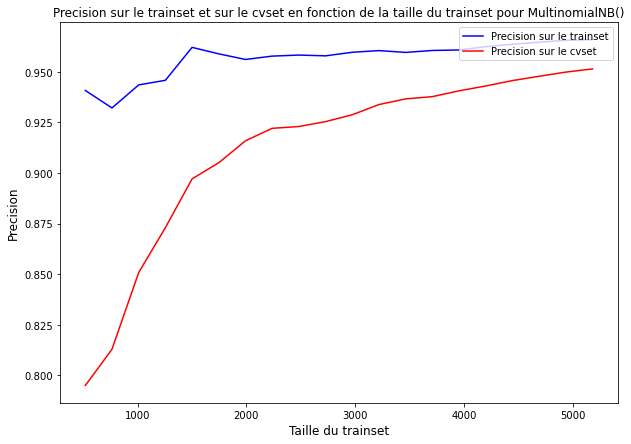

In [52]:
get_learning_curve(model, X_train_tfidf, y_train, cv_param, "precision", train_sizes, n_jobs)

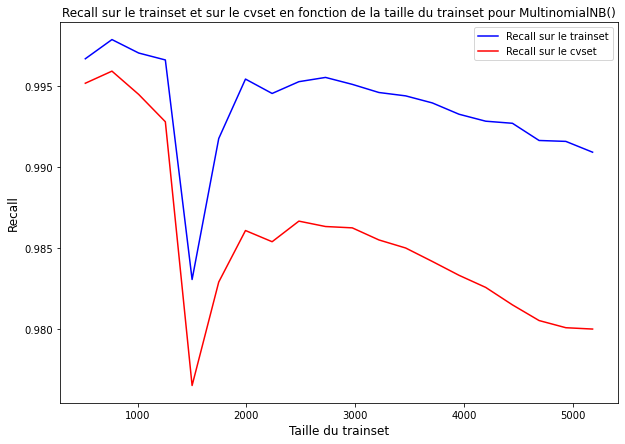

In [53]:
get_learning_curve(model, X_train_tfidf, y_train, cv_param, "recall", train_sizes, n_jobs)

In [16]:
# entrainement du modele
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)

MultinomialNB()

In [21]:
# test du modele
X_test_tfidf = tfidf_vectorizer.transform(X_test)
y_pred = model.predict(X_test_tfidf)
print(y_pred)

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       916
           1       0.95      0.98      0.97      1553

    accuracy                           0.96      2469
   macro avg       0.96      0.95      0.95      2469
weighted avg       0.96      0.96      0.96      2469

[1 1 1 ... 1 1 1]


C:\Users\eupho\AppData\Local\Temp/ipykernel_26648/2510564835.py:19: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_xticklabels([false_label, true_label], Fontsize=font_size + 3)
C:\Users\eupho\AppData\Local\Temp/ipykernel_26648/2510564835.py:20: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  ax.set_yticklabels([false_label, true_label], Fontsize=font_size + 3)


Text(69.0, 0.5, 'Catégories réelles')

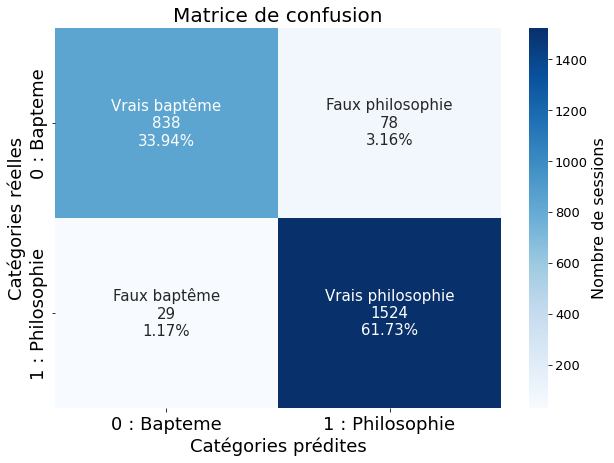

In [29]:
# Matrice de confusion
false_label = "0 : Bapteme"
true_label = "1 : Philosophie"
confusion_matrix_var = confusion_matrix(y_test, y_pred, labels=model.classes_)
group_names = ["Vrais baptême", "Faux philosophie", "Faux baptême", "Vrais philosophie"]
group_counts = ["{0:0.0f}".format(value) for value in
                confusion_matrix_var.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     confusion_matrix_var.flatten()/np.sum(confusion_matrix_var)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)
font_size = 15 #19
plt.rcParams["figure.figsize"] = (10, 7) #taille du graphique, taille du plot
ax = sb.heatmap(confusion_matrix_var, 
                annot=labels, fmt="", cmap='Blues',
                annot_kws={"size": font_size}, 
                cbar_kws={'label': 'Nombre de sessions'})
ax.set_xticklabels([false_label, true_label], Fontsize=font_size + 3)
ax.set_yticklabels([false_label, true_label], Fontsize=font_size + 3)
ax.figure.axes[-1].yaxis.label.set_size(font_size + 1)
ax.figure.axes[-1].tick_params(labelsize=font_size - 2) 
plt.title("Matrice de confusion", fontsize = font_size + 5)
# xlabel = 'Catégories prédites\n\n Exactitude (bien classés) = {:0.2f} % ; Inexactitude (mal classés) = {:0.2f} %\n Précision (bonnes prédictions de robots / qualité) = {:0.2f} %\n Rappel (nombre de robots détectés / quantité) = {:0.2f} %\n F1 (synthèse de précision + rappel) = {:0.2f} %'.format(accuracy, (100 - accuracy), precision, recall, f1_score)
plt.xlabel("Catégories prédites", fontsize=font_size + 3)
plt.ylabel("Catégories réelles", fontsize=font_size + 3)

In [23]:
# Metriques
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       916
           1       0.95      0.98      0.97      1553

    accuracy                           0.96      2469
   macro avg       0.96      0.95      0.95      2469
weighted avg       0.96      0.96      0.96      2469



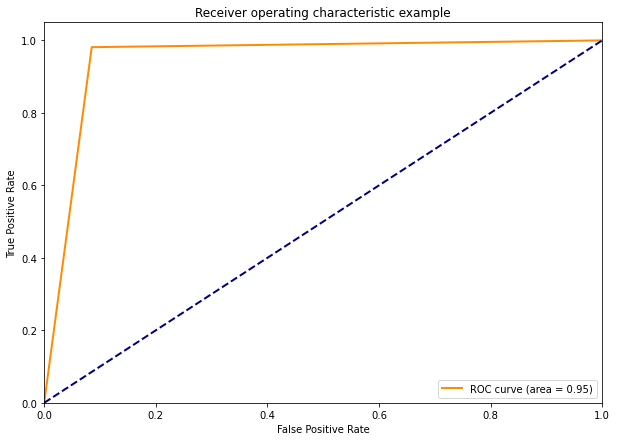

In [39]:
# Courbe ROC et AUC
from sklearn import metrics

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [10]:
# on affiche les documents a propos desquels le modele s'est trompe
corpus_test = pd.DataFrame({"message_preprocessed":X_test, "truth":y_test, "pred":y_pred})
corpus_test_errors = corpus_test.query("truth != pred")
corpus_test_errors = corpus_test_errors[["truth", "pred", "message_preprocessed"]]
corpus_test_errors.to_csv("data/output/prediction_errors.csv", index=False)
corpus_test_errors

,truth,pred,message_preprocessed
7282,baptism,philosophy,salut a sens quand sait fa...
6951,baptism,philosophy,parler enfant légitime non...
5458,baptism,philosophy,« capacité tolérer erreur ...
1192,baptism,philosophy,adresse e-mail publiée cha...
7168,philosophy,baptism,issue cette série crois pr...
7496,philosophy,baptism,jesus loves this i know fo...
3981,baptism,philosophy,médecine devriez savoir mo...
7121,baptism,philosophy,question – comment jésus f...
5140,baptism,philosophy,théorie juste faire beau p...
4430,baptism,philosophy,ceci comme dit frère chari...


In [27]:
print(X_train_tfidf)
X_train_tfidf

  (0, 10537)	0.1633796530792109
  (0, 9621)	0.16311183154213169
  (0, 6435)	0.1863294158248605
  (0, 1217)	0.20225278534533037
  (0, 899)	0.16364960867493525
  (0, 2875)	0.1982623846690439
  (0, 8694)	0.20141621819938454
  (0, 3188)	0.1633796530792109
  (0, 4043)	0.15549858464531688
  (0, 2871)	0.20225278534533037
  (0, 2370)	0.302969034023444
  (0, 10839)	0.1658903754472704
  (0, 9932)	0.20141621819938454
  (0, 10142)	0.23542986649050418
  (0, 4278)	0.1658903754472704
  (0, 7443)	0.09624627443210154
  (0, 1187)	0.11016897123390608
  (0, 8159)	0.1325522042436035
  (0, 1652)	0.19346321058538868
  (0, 1532)	0.09870571208225545
  (0, 3975)	0.3875293898720343
  (0, 7176)	0.15702395311287512
  (0, 551)	0.20225278534533037
  (0, 7337)	0.3326323467475601
  (0, 2758)	0.13148209568170482
  :	:
  (5757, 6354)	0.23637652912131488
  (5757, 471)	0.21866570713650957
  (5757, 3394)	0.20870692582331513
  (5757, 7145)	0.23933253771548715
  (5757, 3582)	0.22646943485964777
  (5757, 9164)	0.1695026917244

<5759x11169 sparse matrix of type '<class 'numpy.float64'>'
	with 133628 stored elements in Compressed Sparse Row format>

In [22]:
print("X_train_tfidf.shape =", X_train_tfidf.shape)
print("X_train_tfidf.data.shape =", X_train_tfidf.data.shape)
print("tfidf_vectorizer.idf_.shape =", tfidf_vectorizer.idf_.shape)

X_train_tfidf.shape = (5759, 11169)
X_train_tfidf.data.shape = (133628,)
tfidf_vectorizer.idf_.shape = (11169,)


In [92]:
# on affiche les poids des mots tfidf
idf = tfidf_vectorizer.idf_
scores_tfidf = pd.DataFrame({"words":tfidf_vectorizer.get_feature_names(), "idf":idf})
scores_tfidf = scores_tfidf.sort_values("idf", ascending=False)
scores_tfidf

c:\Users\eupho\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,words,idf
0,aaaayaajpgpadqthechildofth...,8.965546
5824,lexpérience,8.965546
5857,lillback,8.965546
5852,ligament,8.965546
5844,licence,8.965546
5841,libérateur,8.965546
5840,libéralité,8.965546
5836,librement,8.965546
5834,liberum,8.965546
5831,liberalisme,8.965546


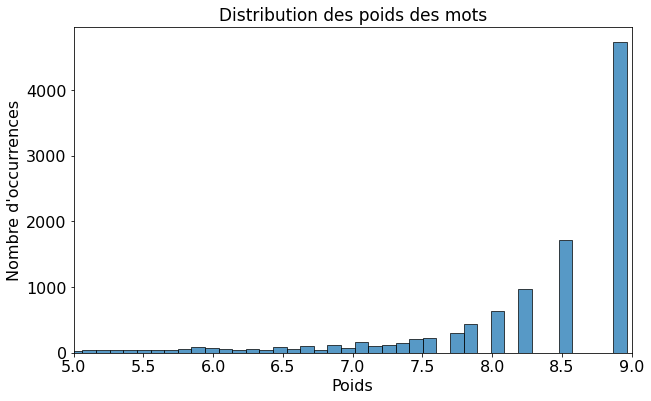

In [101]:
# Distribution des poids des mots (calcules avec sklearn)
path = PureWindowsPath(os.getcwd() + "\\data\\output\\words_weights_distribution.png")
path = path.as_posix()

sb.histplot(data=scores_tfidf, x="idf")
# plt.yscale('log')
plt.xlabel("Poids", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution des poids des mots", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.xlim(5, 9)
plt.savefig(path)
plt.show()

In [17]:
# Calcul manuel des poids
print("X_train_tfidf.shape =", X_train_tfidf.shape)
words_weights = X_train_tfidf.sum(axis=0)
print("words_weights.shape =", words_weights.shape)
print(words_weights)
print(words_weights.shape)

X_train_tfidf.shape = (5759, 11195)
words_weights.shape = (1, 11195)
[[0.28800143 0.37253389 1.02558937 ... 0.12627303 0.22995188 0.68985563]]
(1, 11195)


In [18]:
words_weights = np.ravel(words_weights)
print(words_weights)
print(words_weights.shape)

[0.28800143 0.37253389 1.02558937 ... 0.12627303 0.22995188 0.68985563]
(11195,)


In [33]:
# words_weights[:10]
np.set_printoptions(suppress=True)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
np.unique(words_weights).shape
np.max(words_weights)
np.min(words_weights)

0.03308810017497847

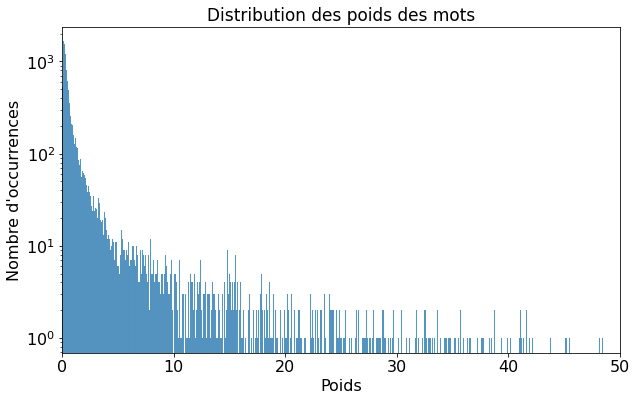

In [36]:
# Distribution des poids des mots (calcules avec a la main)
path = PureWindowsPath(os.getcwd() + "\\data\\output\\words_weights_distribution_manuel.png")
path = path.as_posix()

# sb.histplot(words_weights[:100000])
sb.histplot(words_weights)
plt.yscale('log')
plt.xlabel("Poids", size=16)
plt.ylabel("Nombre d'occurrences", size=16)
plt.title("Distribution des poids des mots", size=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.rcParams["figure.figsize"] = (10, 6)
plt.xlim(0, 50)
plt.savefig(path)
plt.show()